In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image
from skimage import io as skio


# POUR LA MORPHO
#from skimage.morphology import watershed
#from skimage.feature import peak_local_max



In [2]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES:
colaboratory=False#mettre True si vous utilisez google colab
notebook=True   # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()






Loading BokehJS ...

In [4]:
import numpy as np
import tempfile
import IPython
import matplotlib.pyplot as plt
import PIL.Image as pil_image

def viewimage(im, normalize=True,titre='',displayfilename=False):
   imin=im.copy().astype(np.float32)
   if normalize:
       imin-=imin.min()
       if imin.max()>0:
           imin/=imin.max()
   else:
       imin=imin.clip(0,255)/255


   imin=(imin*255).astype(np.uint8)
   filename=tempfile.mktemp(titre+'.png')
   if displayfilename:
       print (filename)
   plt.imsave(filename, imin, cmap='gray')
   IPython.display.display(IPython.display.Image(filename))

#La fonction viewimage_color est la même que viewimage. Ca a l'air de marcher
#USE ONLY viewimage
def viewimage_color(im, normalize=True,titre='',displayfilename=False):
   imin=im.copy().astype(np.float32)
   if normalize:
       imin-=imin.min()
       if imin.max()>0:
           imin/=imin.max()
   else:
       imin=imin.clip(0,255)/255


   imin=(imin*255).astype(np.uint8)
   filename=tempfile.mktemp(titre+'.png')
   if displayfilename:
       print (filename)
   plt.imsave(filename, imin, cmap='gray')
   IPython.display.display(IPython.display.Image(filename))



In [5]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out

def degrade_image(im,br):
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py):
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))

    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]

    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser
# la fonctionnelle E2 par descente de gradient nous avons choisi
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive


def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """

    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=(np.zeros((sy,sx),dtype=complex))
    denom=(np.zeros((sy,sx),dtype=complex))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I):
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax):
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))

    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [6]:
#%% lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())



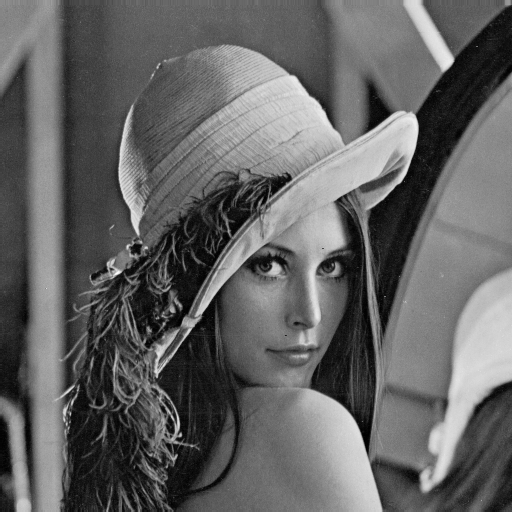

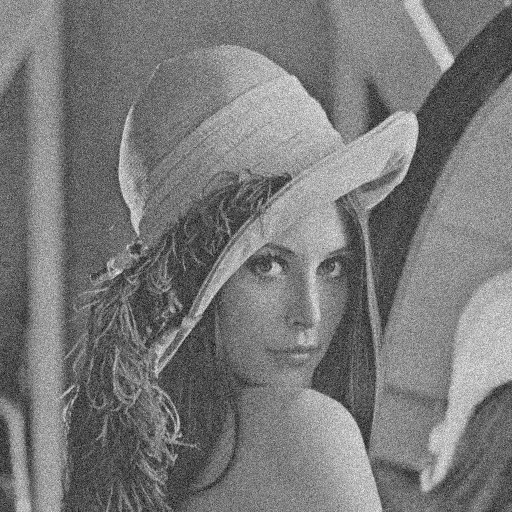

In [7]:
#%%

# voir l'image
viewimage(im,titre='ORIGINALE')
#degrader une image

imb=degrade_image(im,25)

# voir l'image bruitée
viewimage(imb,titre='BRUITEE')



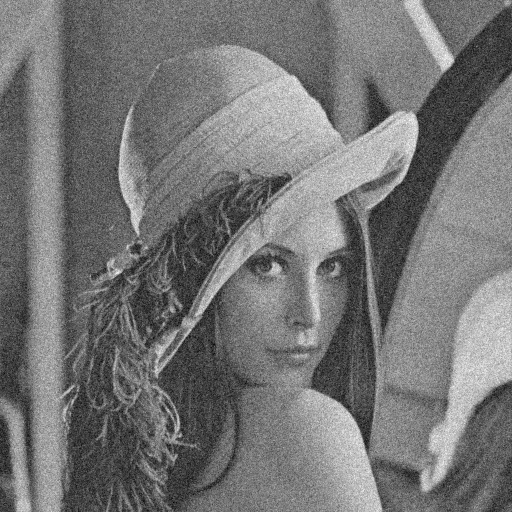

In [8]:
#%% restauration quadratique : exemple
lamb=0.1
restau=minimisation_quadratique(imb,lamb)
viewimage(restau,titre='RESTQUAD_LAMB='+str(lamb))



In [16]:
#question 1.3
imb=degrade_image(im,5) #ajout d'un bruit d'écart type 5
#trouvons le meilleur lambda par dichotomie
d_imb = np.linalg.norm(im-imb)
lambmin = 0
lambmax = 1000
lamb = (lambmin+lambmax)/2
im_restau = minimisation_quadratique(imb,lamb)
d_im_restau = np.linalg.norm(im-im_restau)


while np.abs(d_im_restau-d_imb)>0.1:
    if d_im_restau>d_imb:
        lambmax = lamb
    else:
        lambmin = lamb
    lamb = (lambmin+lambmax)/2
    im_restau = minimisation_quadratique(imb,lamb)
    d_im_restau = np.linalg.norm(im-im_restau)
    print(lamb)



250.0
125.0
62.5
31.25
15.625
7.8125
3.90625
1.953125
0.9765625
0.48828125
0.244140625
0.3662109375
0.30517578125
0.335693359375
0.3509521484375
0.35858154296875
0.354766845703125
0.3566741943359375
0.35762786865234375
0.3581047058105469
0.35834312438964844
0.35822391510009766


0.12


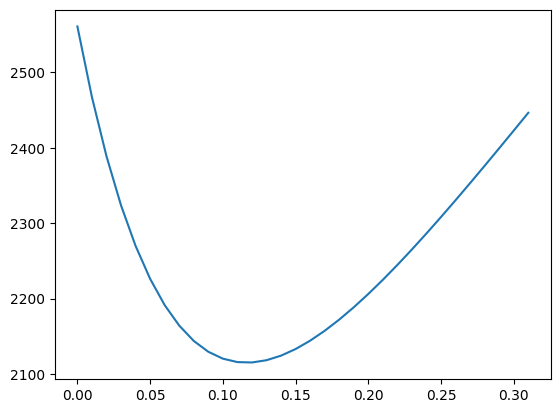

In [19]:
#question 1.4: trouver lamb qui minimise  ∥u˜−u∥
"""
lambmin = 0
im_restau = minimisation_quadratique(imb,lamb)
d = np.linalg.norm(im_restau-imb)
#on cherche le lambda qui minimise la distance entre l'image restaurée et l'image bruitée
for i in range(0,100,1):
    im_restau = minimisation_quadratique(imb,i)
    d_new = np.linalg.norm(im_restau-imb)
    if d_new<d:
        d = d_new
        lambmin = i

print(lambmin)

#donc lambmin est entre 0 et 1

lambmin =0
lamb=0
while lamb<1:
    im_restau = minimisation_quadratique(imb,lambmin)
    d_new = np.linalg.norm(im_restau-imb)
    if d_new<d:
        d = d_new
        lambmin = lamb
    else: lamb+=0.01

print(lambmin)
"""
lambda_min=0
X = []
Y = []
for l in range(0,32):
    l=l/100
    if(norm2(minimisation_quadratique(imb,lambda_min)-im)>norm2(minimisation_quadratique(imb,l)-im)):
        lambda_min=l
    X.append(l)
    Y.append(norm2(minimisation_quadratique(imb,l)-im))

plt.plot(X,Y)
print(lambda_min)

    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


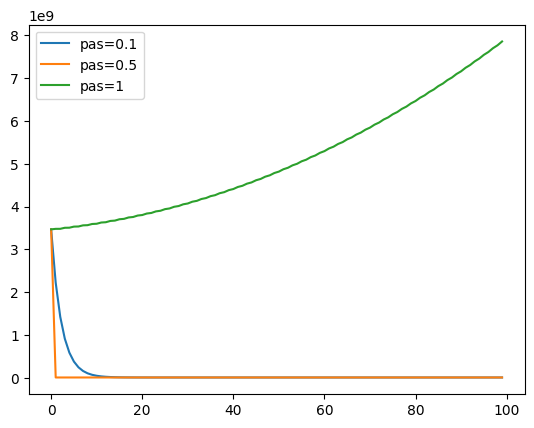

In [28]:
#question 2.1: Descente de gradient pour minimiser E2
lamb=5
pas=0.1
nbpas=100
#u_restau, Ener = minimise_TV_gradient(im,lamb,pas,nbpas)
#viewimage(u_restau,titre='RESTTV_LAMB='+str(lamb))
#print(Ener)
imb=degrade_image(im,25)
(u,energ)=minimise_TV_gradient(imb,0.5,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,0.5,0.5,100)       # pas = 0.5
(u,energ3)=minimise_TV_gradient(imb,0.5,1,100)  

plt.plot(energ, label='pas=0.1')
plt.plot(energ2, label='pas=0.5')
plt.plot(energ3, label='pas=1')

plt.legend()
plt.show()


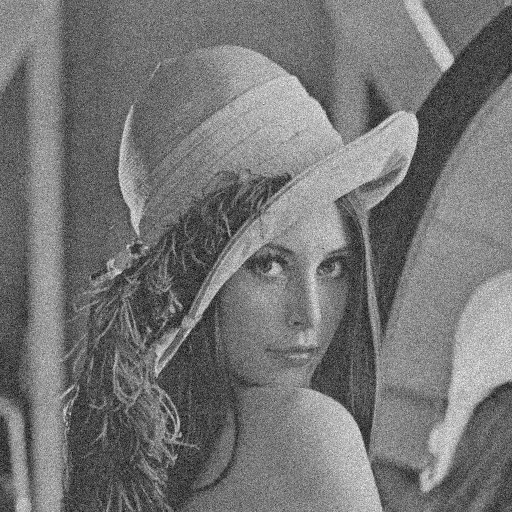

In [30]:
# question 2.2 méthode de Chambolle
lamb=0.5
itmax=100
u_restau=vartotale_Chambolle(imb,lamb,itmax)
viewimage(u_restau,titre='RESTCHAMB_LAMB='+str(lamb))


0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
1.7378008287493754
1.1748975549395295


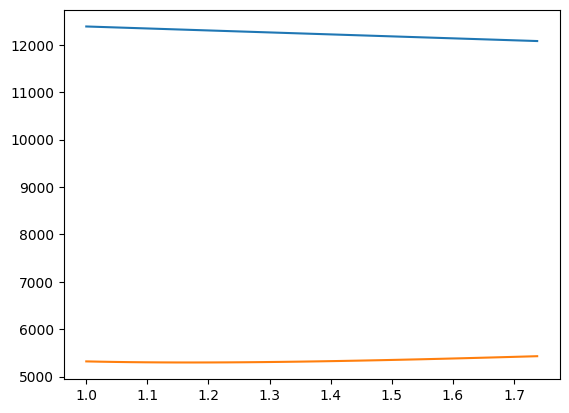

In [39]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs
# parametres de regularisation

myim=imread('lena.tif')
imb=degrade_image(im,25)

errq=[]
errvt=[]
erreur=[]
vk=np.arange(0,0.25,0.01);
for k in vk:
    print (k)
    #restq=minimisation_quadratique(imb,10^(k)); #
    #errq.append(norm2(restq-myim));#
    restva=vartotale_Chambolle(imb,10**(k)); #
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    errvt.append(norm2(restva-myim));



plt.plot(10**vk,errvt);
plt.plot(10**vk,erreur);

#print le meilleur lambda pour chaque méthode
print(10**vk[np.argmin(errvt)])
print(10**vk[np.argmin(erreur)])




In [ ]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)


In [ ]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ)
plt.plot(energ2)
